In [46]:
import GPy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

%matplotlib inline

In [24]:
tsla = pd.read_csv('../data/raw/financial/tsla.csv').sort_index(ascending=False)
tsla['Date'] = pd.to_datetime(tsla['Date'])
tsla.head()

,Date,Open,High,Low,Close,Volume
251,2015-05-05,237.76,239.50,229.13,232.95,5796873
250,2015-05-06,234.10,234.47,228.20,230.43,5270933
249,2015-05-07,221.00,237.48,220.25,236.80,9455909
248,2015-05-08,235.99,238.41,233.70,236.61,4668236
247,2015-05-11,236.29,242.88,235.31,239.49,5672262


In [36]:
# regress over days since the first date seen
dates = tsla['Date'].as_matrix()
first_date = np.min(dates)

T = np.zeros_like(dates).astype(float).reshape(-1,1)
for i, t in np.ndenumerate(dates):
    T[i] = (t - first_date) / np.timedelta64(1, 'D')

T[:5].T

array([[ 0.,  1.,  2.,  3.,  6.]])

In [37]:
price = tsla['Open'].as_matrix().reshape(-1,1)
price[:5].T

array([[ 237.76,  234.1 ,  221.  ,  235.99,  236.29]])

Text(0.5,0,'Days Since 05-05-2015')

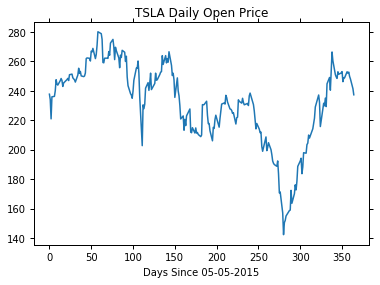

In [45]:
plt.plot(T, price)
plt.title('TSLA Daily Open Price')
plt.xlabel('Days Since {}'.format(pd.to_datetime(first_date).strftime('%d-%m-%Y')))

Now let's try running Gaussian Process regression on these stock prices, using a poor choice of hyperparameters. Within the RBF (aka. Squared Exponential) kernel,

$$
\kappa(x,x') = \sigma_f \exp(-||x - x'||^2/(2\ell^2))
$$

the lengthscale $\ell$, when small, means that each point only depends on the points _very_ close to it. For our data, having points at every integer along an interval, having a lengthscale of 0.75 means that the closest point away will be weighted at about $-\sigma_f$. This means that our function will be pulled to the mean $\mu=0$ very quickly, resulting in a plot that looks almost piecewise linear.

The variance $\sigma_f$ controls how 'wiggly' the function is. By increasing this, with small lengthscale $\ell$, you end up being pulled to the mean very quickly.

We can see these affects below.

In [50]:
kernel = GPy.kern.RBF(input_dim=1, variance=1.5, lengthscale=0.75)
model  = GPy.models.GPRegression(T, price, kernel=kernel, noise_var=0.2)
display(model)

GP_regression.,value,constraints,priors
rbf.variance,1.5,+ve,
rbf.lengthscale,0.75,+ve,
Gaussian_noise.variance,0.2,+ve,


 /usr/local/lib/python3.5/site-packages/matplotlib-1.5.1+1795.g515ba4b-py3.5-macosx-10.10-x86_64.egg/matplotlib/figure.py:1845: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


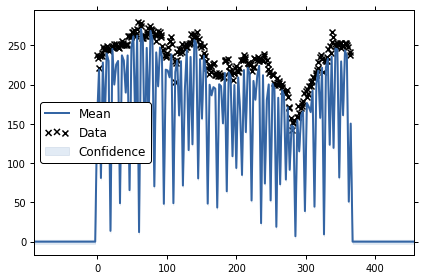

In [51]:
model.plot()

Now let us find the optimal parameters by maximizing the marginal likelihood over our data.  This results in a very smooth function. Note that the optimal lengthscale is about a month, and the optimal variance is about \$25K.

In [54]:
model.optimize()
display(model)

GP_regression.,value,constraints,priors
rbf.variance,24245.3542512,+ve,
rbf.lengthscale,29.5511807116,+ve,
Gaussian_noise.variance,52.6761026369,+ve,


 /usr/local/lib/python3.5/site-packages/matplotlib-1.5.1+1795.g515ba4b-py3.5-macosx-10.10-x86_64.egg/matplotlib/figure.py:1845: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


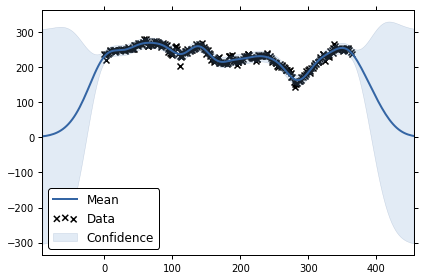

In [53]:
model.plot()